# Вычисление параметров для молекулярной механики

In [ ]:
#импорт библиотек
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize 
import subprocess

In [17]:
length_start = 1.52986
HCC_start = 111.200
CC_start = 0

inp = '''!HF RHF 6-31G
* int 0 1
C 0 0 0 0 0 0 
C 1 0 0 {0} 0 0 
H 1 2 0 1.08439 {1} 0
H 1 2 3 1.08439 {1} 120
H 1 2 3 1.08439 {1} -120
H 2 1 3 1.08439 {1} {2} 
H 2 1 6 1.08439 {1} 120
H 2 1 6 1.08439 {1} -120
*
'''
# координаты атомов 7 и 8 заданы относительно 6, 
# поэтому если его поворачивать, то 7 и 8 будут поворачиваться согласованно

In [18]:
def get_inp(length, HCC, CC):
    return inp.format(length, HCC, CC)

In [19]:
def run_orca(inp):
    
    with open('orca.inp', 'w') as outfile: 
        outfile.write(inp)
    p = subprocess.Popen("/srv/databases/orca/orca orca.inp", 
                          shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out=p.communicate()[0]
    outlines = out.splitlines()

    for l in outlines:
        if 'FINAL SINGLE' in str(l):
            return float(l.split()[-1])

In [20]:
run_orca(get_inp(length_start, HCC_start, CC_start))

-79.192987718035

# Зависимость энергии молекулы от длины одной связи

In [21]:
x_o = np.arange(1.3, 1.7, 0.02)

In [22]:
y_o = np.array([run_orca(get_inp(i, HCC_start, CC_start)) for i in x_o])

In [23]:
fitfunc = lambda p, x: p[0] * (p[1] - x) ** 2 + p[2] # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Error function

In [24]:
p0 = [1,1, -79] # Initial guess for the parameters
res = optimize.least_squares(errfunc, p0[:], args=(x_o, y_o), verbose=2, method='lm')
p1 = res.x
print("Optimized params:", p1)

Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 17, initial cost 2.0422e+00, final cost 2.3159e-05, first-order optimality 2.80e-09.
Optimized params: [  0.78811492   1.55416065 -79.19468557]


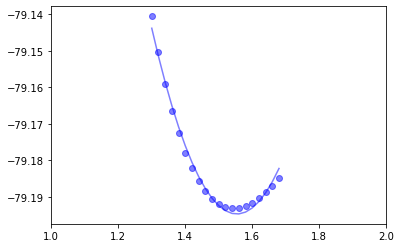

In [25]:
#Plot it
plt.plot(x_o, y_o, "ro", x_o,fitfunc(p1,x_o),"r-",c='blue',alpha=0.5)
plt.xlim(1,2)
plt.show()

Величина длины связи CC равна 1.526Å в параметрах поля GAFF. (J. Wang, R. M. Wolf, J. W. Caldwell, P. A. Kollman, and D. A. Case, "Development and testing of a general amber force field")

Найденный в расчетах минимум экспериментальных значений близок к значению в поле, имеющиеся различия могут быть связаны с  использованием авторами других базисов для расчета и помимо ab initio вычислений авторы использовали и данные из кристаллических структур и силового поля Amber.

# Зависимость энергии молекулы от валентного угла HCC

In [26]:
x_o1 = np.arange(109.2, 113.2, 0.2)

In [27]:
y_o1 = np.array([run_orca(get_inp(length_start, i, CC_start)) for i in x_o1])

In [28]:
p0 = [1,1, 0] # Initial guess for the parameters
res = optimize.least_squares(errfunc, p0[:], args=(x_o1, y_o1), verbose=2, method='lm')
p1 = res.x
print("Optimized params:", p1)

`xtol` termination condition is satisfied.
Function evaluations 25, initial cost 1.4897e+09, final cost 5.4723e-12, first-order optimality 1.52e-09.
Optimized params: [ 3.50061281e-04  1.11774884e+02 -7.91931033e+01]


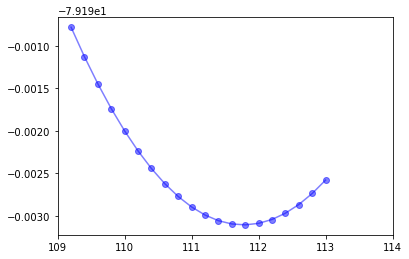

In [29]:
#Plot it
plt.plot(x_o1, y_o1, "ro", x_o1,fitfunc(p1,x_o1),"r-",c='blue',alpha=0.5)
plt.xlim(109,114)
plt.show()

# Зависимость энергии молекулы от торсионного угла CC

In [30]:
x_o2 = np.arange(-180, 181, 12)

In [31]:
y_o2 = np.array([run_orca(get_inp(length_start, HCC_start, i)) for i in x_o2])

In [32]:
fitfunc = lambda p, x: p[0] * np.cos(x * p[1] * (np.pi) / 180 - p[2]) - p[3] # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Error function

In [33]:
p0 = [1, 2.5, 0, 0] # Initial guess for the parameters
res = optimize.least_squares(errfunc, p0[:], args=(x_o2, y_o2), verbose=2, xtol=1e-15, method='lm')
p1 = res.x
print("Optimized params:", p1)

`ftol` termination condition is satisfied.
Function evaluations 46, initial cost 9.7518e+04, final cost 1.5441e-10, first-order optimality 7.75e-10.
Optimized params: [2.29205027e-03 3.00017741e+00 1.41662437e-10 7.91952842e+01]


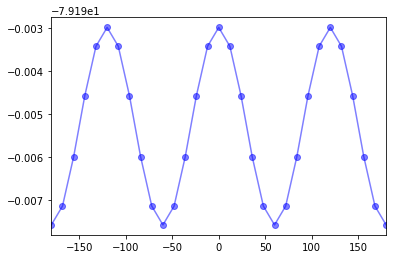

In [34]:
#Plot it
plt.plot(x_o2, y_o2, "ro", x_o2,fitfunc(p1,x_o2),"r-",c='blue',alpha=0.5)
plt.xlim(-180, 180)
plt.show()

Здесь видны три минимума, соответствующие заторможенной конформации этана: один на 180 (а.к. -180) и два на -60, 60. 3 максимума соответствуют заслоненной конформации (120, -120 и 0).